# LUS-CS433

in this notebook we explore deep learning solutions for our classification problem. Our goal is to train a binary classifier able to select relevant LUS images from a LUS video.
Note that code from this notebook is to a great extent taken from an official PyTorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### Imports 

In [34]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
from cumulator import base
import sys

In [2]:
cumulator = base.Cumulator()

## 1. Transfer learning approach

TODO
In hope of reducing computing time, we aim at using transfer learning to train an LUS image binary classifier 

### 1.1 Loading Data

In [58]:
# Data augmentation and normalization for training
# Just normalization for validation

# TODO Do we need these augmentations ?

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/butter_proc_images_2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataloaders_test = torch.utils.data.DataLoader(image_datasets['test'], batch_size=1,
                                             shuffle=False, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

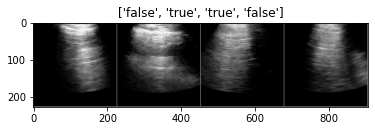

In [59]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.2 Model training

In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [62]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [63]:
cumulator.on()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
cumulator.off()

Epoch 0/24
----------
train Loss: 0.5529 Acc: 0.7551
val Loss: 1.3108 Acc: 0.5085

Epoch 1/24
----------
train Loss: 0.5268 Acc: 0.7942
val Loss: 2.0950 Acc: 0.5085

Epoch 2/24
----------
train Loss: 0.7354 Acc: 0.8086
val Loss: 7.5895 Acc: 0.4915

Epoch 3/24
----------
train Loss: 0.4733 Acc: 0.8374
val Loss: 1.9000 Acc: 0.5424

Epoch 4/24
----------
train Loss: 0.3889 Acc: 0.8724
val Loss: 2.0861 Acc: 0.5254

Epoch 5/24
----------
train Loss: 0.4434 Acc: 0.8601
val Loss: 5.8636 Acc: 0.5085

Epoch 6/24
----------
train Loss: 0.5429 Acc: 0.8354
val Loss: 2.3208 Acc: 0.7373

Epoch 7/24
----------
train Loss: 0.2862 Acc: 0.9218
val Loss: 0.0510 Acc: 0.9831

Epoch 8/24
----------
train Loss: 0.2867 Acc: 0.9012
val Loss: 0.0142 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2042 Acc: 0.9280
val Loss: 0.1139 Acc: 0.9407

Epoch 10/24
----------
train Loss: 0.1476 Acc: 0.9444
val Loss: 0.0153 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1489 Acc: 0.9383
val Loss: 0.0161 Acc: 1.0000

Ep

In [64]:
cumulator.total_carbon_footprint()

11.482735701799392

### 1.3 Model saving

In [65]:
torch.save(model_ft.state_dict(), "models/27_11_resnet18_noRandCrop_butter2")

In [14]:
#!zip resulsmodels classifier.ipynb

tensor([[-0.5566,  0.5398],
        [-2.6406,  4.7696],
        [-2.5625,  5.7581],
        [-2.5375,  4.7918]], device='cuda:0')


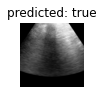

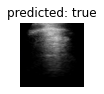

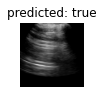

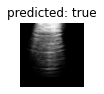

tensor([[ 1.5351, -2.1501],
        [ 1.6226, -0.9591],
        [ 2.8026, -2.0122],
        [ 1.5595, -1.4272]], device='cuda:0')


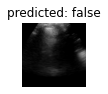

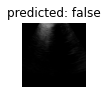

In [40]:
visualize_model(model_ft)

In [15]:
inputs, classes = next(iter(dataloaders['val']))
inputs = inputs.to(device)
model_ft(inputs)

tensor([[-1.8101, -0.5432],
        [-4.7625,  3.2300],
        [-4.5055,  2.7709],
        [-3.0251,  2.3430]], device='cuda:0', grad_fn=<AddmmBackward>)

In [17]:
nn.functional.softmax(model_ft(inputs))

<ipython-input-17-e3047d1493ab>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.functional.softmax(model_ft(inputs))


tensor([[2.1978e-01, 7.8022e-01],
        [3.3786e-04, 9.9966e-01],
        [6.9120e-04, 9.9931e-01],
        [4.6414e-03, 9.9536e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [71]:
model_test = models.resnet18(pretrained=True)
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 2)
model_test.load_state_dict(torch.load("models/27_11_resnet18_natural_butter2"))
model_test = model_test.to(device)
model_test.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
imgs_path = [img[0] for img in dataloaders_test.dataset.imgs]

In [68]:
!mkdir data\butter_proc_images_2\results_norandcrop
!mkdir data\butter_proc_images_2\results_norandcrop\good
!mkdir data\butter_proc_images_2\results_norandcrop\average
!mkdir data\butter_proc_images_2\results_norandcrop\bad

In [72]:
def do_split(path) :
    if(sys.platform.startswith('linux')) :
        return path.split('/')
    else :
        return path.split('\\')

good_count = 0
avg_count = 0
bad_count = 0
write_path = "data/butter_proc_images_2/results"
for (img, _), path in zip(dataloaders_test, imgs_path) :
    img = img.to(device)
    prob_good = nn.functional.softmax(model_test(img), dim = 1)[0, 1]
    img_read = cv2.imread(path)
    img_name = do_split(path)[-1]
    folder = "average"
    if(prob_good >= 0.6) :
        folder = "good"
        good_count += 1
    elif(prob_good <= 0.2) :
        folder = "bad"
        bad_count += 1
    else :
        avg_count += 1
        
    cv2.imwrite(f"{write_path}/{folder}/{img_name}", img_read)
print(f"There are {good_count} good, {avg_count} average and {bad_count} bad images.")

There are 7 good, 38 average and 248 bad images.
